# Tutorial 2: 
# Image Classification Model: Convolution Neural Networks

## 1- Importing libraries

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
%matplotlib inline

/home/instadeeprd/miniconda3/envs/learn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2- Data pre-processing and data augmentation

Image Shape: (28, 28)


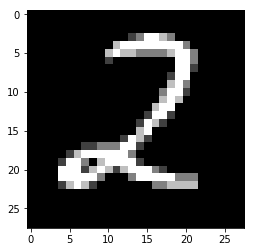

In [2]:
im = Image.open("/media/instadeeprd/DATA/Education/DL_course/TP2/testing/2/477.png")
im = np.array(im)
print("Image Shape:", im.shape)
plt.imshow(im, cmap="gray")

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.


These are just a few of the options available (for more, see the documentation). Let's quickly go over what we just wrote:

* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Found 10000 images belonging to 10 classes.
(1, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


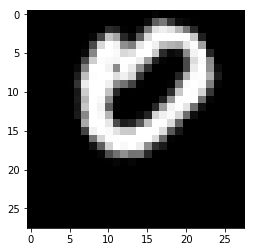

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                  shear_range=0.2, #is for randomly applying shearing transformations
                                  zoom_range=0.2, #is for randomly zooming inside pictures
                                  horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                  rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                  width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                  height_shift_range=0.2, 
                                  fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                 )


validation_generator = test_datagen.flow_from_directory("testing", batch_size=1, 
                                                        class_mode='categorical', 
                                                        color_mode='grayscale', 
                                                        target_size=(28,28)
                                                       )
for x, y in validation_generator:
    print(x.shape)
    print(y)
    plt.imshow(x[0,:,:,0], cmap='gray')
    break

## 3- Object Oriented Programming

In [4]:
class Image_Classifier():
    def __init__(self, train_folder='data/train', validation_folder='data/validation', 
                  inshape=(28,28,1), num_classes=10, num_train=1000, num_validation=200):
        self.train_folder = train_folder
        self.validation_folder =  validation_folder
        self.inshape = inshape
        self.num_classes = num_classes
        self.num_train = num_train
        self.num_validation = num_validation
        
    def model(self, inshape=(28,28,1), num_classes=10, learning_rate=0.001):
        '''
            Three steps to Convolution
                1. Convolution
                2. Activation
                3. Polling
            Repeat Steps 1,2,3 for adding more hidden layers
                4. After that make a fully connected network
            This fully connected network gives ability to the CNN
            to classify the samples
        '''
        model = Sequential()

        model.add(Convolution2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                         input_shape=inshape, 
                         data_format="channels_last")
                 )
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Convolution2D(filters = 32, kernel_size=(3, 3), strides=(1, 1)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        
        model.add(Flatten())

        model.add(Dense(512))
        model.add(Activation('relu'))
        model.add(Dropout(0.2))

        model.add(Dense(num_classes, activation='softmax'))
        # Binary cross-entropy is for multi-label classifications, whereas categorical cross entropy is for multi-class classification where each example belongs to a single class.
        optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        return model
    
    def train(self, batch_size=128, epochs=12, learning_rate=0.001, model_file="my_model.h5", refine = False):
        '''
            Train Process
        '''
        # this is the augmentation configuration we will use for training
        train_datagen = ImageDataGenerator(rescale=1./255, # is a value by which we will multiply the data before any other processing
                                            shear_range=0.2, #is for randomly applying shearing transformations
                                            zoom_range=0.2, #is for randomly zooming inside pictures
                                            horizontal_flip=True, #is for randomly flipping half of the images horizontally
                                            #rotation_range=40, #is a value in degrees (0-180), a range within which to randomly rotate pictures
                                            #width_shift_range=0.2, #which to randomly translate pictures vertically or horizontally
                                            #height_shift_range=0.2, 
                                            #fill_mode='nearest' #is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.
                                          )

        # this is the augmentation configuration we will use for testing:
        # only rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)

        # this is a generator that will read pictures found in
        # subfolers of 'data/train', and indefinitely generate
        # batches of augmented image data
        train_generator = train_datagen.flow_from_directory(self.train_folder,  # this is the target directory
                                                            target_size=(28,28),  # all images will be resized to 150x150
                                                            batch_size=batch_size, 
                                                            color_mode='grayscale',
                                                            #class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels
                                                           )
        # this is a similar generator, for validation data
        validation_generator = test_datagen.flow_from_directory(self.validation_folder, 
                                                                target_size=(28,28),
                                                                batch_size=batch_size, 
                                                                color_mode='grayscale',
                                                                #class_mode='binary'
                                                               )
        if refine:
            model = load_model(model_file)
        else:
            model = self.model(inshape=self.inshape, num_classes=self.num_classes, learning_rate=learning_rate)
        
        model.fit_generator(train_generator,
                            steps_per_epoch=self.num_train // batch_size,
                            epochs=epochs,
                            validation_data=validation_generator,
                            validation_steps=self.num_validation // batch_size)
        
        # You can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:
        # 1- the architecture of the model, allowing to re-create the model
        # 2- the weights of the model
        # 3- the training configuration (loss, optimizer)
        # 4- the state of the optimizer, allowing to resume training exactly where you left off.

        model.save(model_file)
        
        
    def predict(self, x, model_file="my_model.h5"):
        model = load_model(model_file)
        prediction = model.predict(x)
        return prediction

## 4- Training Step

In [5]:
im_classifier = Image_Classifier(train_folder = 'training', validation_folder = 'testing', 
                                 inshape=(28,28,1), num_classes=10,
                                 num_train=60000, num_validation=1000)

im_classifier.train(batch_size=128, epochs=12, learning_rate=0.001)

Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Epoch 1/12
468/468 [==============================] - 126s 270ms/step - loss: 0.3991 - acc: 0.8718 - val_loss: 0.1020 - val_acc: 0.9665
Epoch 2/12
468/468 [==============================] - 41s 87ms/step - loss: 0.1381 - acc: 0.9569 - val_loss: 0.0531 - val_acc: 0.9833
Epoch 3/12
468/468 [==============================] - 41s 87ms/step - loss: 0.1018 - acc: 0.9680 - val_loss: 0.0373 - val_acc: 0.9888
Epoch 4/12
468/468 [==============================] - 41s 87ms/step - loss: 0.0862 - acc: 0.9723 - val_loss: 0.0434 - val_acc: 0.9888
Epoch 5/12
468/468 [==============================] - 41s 87ms/step - loss: 0.0742 - acc: 0.9766 - val_loss: 0.0359 - val_acc: 0.9877
Epoch 6/12
468/468 [==============================] - 41s 87ms/step - loss: 0.0682 - acc: 0.9787 - val_loss: 0.0359 - val_acc: 0.9866
Epoch 7/12
468/468 [==============================] - 46s 98ms/step - loss: 0.0621 - acc: 0.9799 - val_los

## 5- Inference Step

In [6]:
im = Image.open("/media/instadeeprd/DATA/Education/DL_course/TP2/testing/6/870.png")
im = np.array(im)
im = np.expand_dims(im, axis=0)
im = np.expand_dims(im, axis=3)
print(im.shape)
im_classifier = Image_Classifier()
prediction = im_classifier.predict(im, model_file="my_model.h5")
prediction_digit = prediction[0].argmax()
print("The corresponding image digit is :", prediction_digit)

(1, 28, 28, 1)
The corresponding image digit is : 6


# Tutorial 2: Part II 
# Fine-tuning the top layers of a pre-trained network (Transfert Learning)
Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates.
* instantiate the convolutional base of the model and load its weights
* add our defined fully-connected model on top, and load its weights
* freeze the layers of the pretrained model up to the last convolutional block

Here a list of the most famous CNN models:

https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html

In [9]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [10]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet') #, include_top=False)

<img src="figures/inceptionv3.png">

<img src="vgg16_modified.png">

In [11]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_3
2 batch_normalization_1
3 activation_4
4 conv2d_4
5 batch_normalization_2
6 activation_5
7 conv2d_5
8 batch_normalization_3
9 activation_6
10 max_pooling2d_3
11 conv2d_6
12 batch_normalization_4
13 activation_7
14 conv2d_7
15 batch_normalization_5
16 activation_8
17 max_pooling2d_4
18 conv2d_11
19 batch_normalization_9
20 activation_12
21 conv2d_9
22 conv2d_12
23 batch_normalization_7
24 batch_normalization_10
25 activation_10
26 activation_13
27 average_pooling2d_1
28 conv2d_8
29 conv2d_10
30 conv2d_13
31 conv2d_14
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_9
37 activation_11
38 activation_14
39 activation_15
40 mixed0
41 conv2d_18
42 batch_normalization_16
43 activation_19
44 conv2d_16
45 conv2d_19
46 batch_normalization_14
47 batch_normalization_17
48 activation_17
49 activation_20
50 average_pooling2d_2
51 conv2d_15
52 conv2d_17
53 conv2d_20
54 conv2d_21
55 batch_normalization_13
56 batch_

## Create a new model
Now that we have set the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base. We will simply add a fully connected layer followed by a softmax layer with 3 outputs. This is done as given below.

## Load the pre-trained model
First, we will load a inception-v3 model without the top layer ( which consists of fully connected layers ).

In [12]:
# create the base pre-trained model over a custom input tensor
# Giving that the default input shape is (299,299,3)
# Change the input shape
# this could also be the output a different Keras model or layer
print(K.image_data_format())
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(139, 139, 3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(10, activation='softmax')(x)


# Add new layers
# model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(3, activation='softmax'))
 
    
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

channels_last


## Freeze the required layers
In Keras, each layer has a parameter called “trainable”. For freezing the weights of a particular layer, we should set this parameter to False, indicating that this layer should not be trained. That’s it! We go over each layer and select which layers we want to train.

In [13]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False